EVA2 JOSE FUENZALIDA

Los datos a utilizar corresponden a un registro agricola de rendimiento de produccion calculado en toneladas, donde las columnas se encuentran etiquetadas. Se tomara como columna objetivo para el entrenamiento la produccion final medida en toneladas por hectarea "Yield_tons_per_hectare". Como objetivo se pretende utilizar este dataset para entrenar un modelo Random Forest y determinar su rendimiento al igual que la importancia de los parametros adyacentes utilizados para predecir el rendimiento

**_CARGA DE DATOS_**

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

spark = SparkSession.builder.appName("AgriculturalYieldPrediction").getOrCreate()
spark.conf.set("spark.sql.shuffle.partitions", "200")

print("✓ Sesión Spark iniciada")
print(f"  Versión: {spark.version}")

archivo_csv = "/Volumes/workspace/ml_eva2/eva2/DATASET_DEFINITIVO.csv"

try:
    df_spark = spark.read.format("csv") \
        .option("header", "true") \
        .option("inferSchema", "true") \
        .load(archivo_csv)
    print(f"  Ruta: {archivo_csv}")
    print(f"  Carga exitosa")
except Exception as e:
    print(f"Error al cargar el archivo CSV: {e}")


✓ Sesión Spark iniciada
  Versión: 4.0.0
  Ruta: /Volumes/workspace/ml_eva2/eva2/DATASET_DEFINITIVO.csv
  Carga exitosa


**_Exploración del Dataset con Spark_**

In [0]:
if df_spark is not None:
    print("="*80)
    print("INFORMACIÓN DEL DATASET (SPARK)")
    print("="*80)
    
    print(f"\n Dimensiones:")
    print(f"  Filas: {df_spark.count()}")
    print(f"  Columnas: {len(df_spark.columns)}")
    
    print(f"\n Esquema:")
    df_spark.printSchema()
else:
    print("Error")

INFORMACIÓN DEL DATASET (SPARK)

 Dimensiones:
  Filas: 20276
  Columnas: 10

 Esquema:
root
 |-- Region: string (nullable = true)
 |-- Soil_Type: string (nullable = true)
 |-- Crop: string (nullable = true)
 |-- Rainfall_mm: double (nullable = true)
 |-- Temperature_Celsius: double (nullable = true)
 |-- Fertilizer_Used: boolean (nullable = true)
 |-- Irrigation_Used: boolean (nullable = true)
 |-- Weather_Condition: string (nullable = true)
 |-- Days_to_Harvest: integer (nullable = true)
 |-- Yield_tons_per_hectare: double (nullable = true)



**_Columna a Utilizar_**

In [0]:
COLUMNA_TARGET = "Yield_tons_per_hectare"

# Verificar que la columna existe
if COLUMNA_TARGET not in df_spark.columns:
    print(f" Advertencia: La columna '{COLUMNA_TARGET}' no existe")
    print(f"Columnas disponibles: {df_spark.columns}")
else:
    print(f"✓ Columna target '{COLUMNA_TARGET}' identificada")
    
    # Mostrar estadísticas del target
    print(f"\n Estadísticas de Producción (Toneladas):")
    target_stats = df_spark.select(
        min(COLUMNA_TARGET).alias("Min"),
        max(COLUMNA_TARGET).alias("Max"),
        avg(COLUMNA_TARGET).alias("Promedio"),
        stddev(COLUMNA_TARGET).alias("Desv. Estándar")
    )
    target_stats.show()

✓ Columna target 'Yield_tons_per_hectare' identificada

 Estadísticas de Producción (Toneladas):
+-------------------+-----------------+-----------------+------------------+
|                Min|              Max|         Promedio|    Desv. Estándar|
+-------------------+-----------------+-----------------+------------------+
|-0.4692287826459278|9.727003962492544|4.643100187157361|1.7073756046186506|
+-------------------+-----------------+-----------------+------------------+



**_Preprocesamiento con Spark SQL_**

In [0]:
print(" Iniciando preprocesamiento con Spark...")

# Eliminar valores nulos
df_clean = df_spark.na.drop()

print(f"\n✓ Limpieza de datos:")
print(f"  Filas antes: {df_spark.count()}")
print(f"  Filas después: {df_clean.count()}")
print(f"  Filas eliminadas: {df_spark.count() - df_clean.count()}")

# Identificar columnas numéricas y categóricas
numeric_cols = [field.name for field in df_clean.schema.fields if isinstance(field.dataType, (IntegerType, DoubleType, FloatType))]
categorical_cols = [field.name for field in df_clean.schema.fields if isinstance(field.dataType, StringType)]

print(f"\n Análisis de columnas:")
print(f"  Columnas numéricas: {len(numeric_cols)}")
print(f"    {numeric_cols}")
print(f"  Columnas categóricas: {len(categorical_cols)}")
print(f"    {categorical_cols}")

# Remover target de features
feature_cols = [col for col in numeric_cols if col != COLUMNA_TARGET]

print(f"\n✓ Características finales ({len(feature_cols)}):")
print(f"  {feature_cols}")

 Iniciando preprocesamiento con Spark...

✓ Limpieza de datos:
  Filas antes: 20276
  Filas después: 20276
  Filas eliminadas: 0

 Análisis de columnas:
  Columnas numéricas: 4
    ['Rainfall_mm', 'Temperature_Celsius', 'Days_to_Harvest', 'Yield_tons_per_hectare']
  Columnas categóricas: 4
    ['Region', 'Soil_Type', 'Crop', 'Weather_Condition']

✓ Características finales (3):
  ['Rainfall_mm', 'Temperature_Celsius', 'Days_to_Harvest']


**_Arquitectura de Datos en Capas_**

In [0]:
print("=" * 80)
print("ARQUITECTURA DE DATOS - CAPA RAW")
print("=" * 80)

raw_data = df_spark
row_count_raw = raw_data.count()

print(f"✓ Capa Raw: Dataset Original sin transformaciones")
print(f"  Registros: {row_count_raw}")
print(f"  Columnas: {len(raw_data.columns)}")
print(f"  Almacenamiento: DBFS/CSV")

print(f"\n Muestra de datos raw (primeras 3 filas):")
raw_data.limit(3).show(truncate=False)

print("\n" + "=" * 80)

print("\n" + "=" * 80)
print("ARQUITECTURA DE DATOS - CAPA PROCESSED")
print("=" * 80)

from pyspark.sql.functions import variance
var_df = df_clean.select([variance(c).alias(c) for c in feature_cols])
var_row = var_df.collect()[0].asDict()
top_features = sorted(var_row, key=var_row.get, reverse=True)[:1]

assembler = VectorAssembler(
    inputCols=top_features,
    outputCol="features_raw"
)

df_assembled = assembler.transform(df_clean)
df_assembled_sample = df_assembled.sample(False, 0.05, seed=42)

scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features_scaled",
    withMean=True,
    withStd=True
)

scaler_model = scaler.fit(df_assembled_sample)
df_scaled = scaler_model.transform(df_assembled)

df_processed = df_scaled.select(COLUMNA_TARGET, "features_scaled")

print(f"✓ Capa Processed: Datos normalizados con StandardScaler")
print(f"  Registros: {df_processed.count()}")
print(f"  Características normalizadas: {len(top_features)}")
print(f"  Normalizacion aplicada: Media=0, Desv. Estándar=1")

print(f"\n Muestra datos procesados:")
df_processed.select(COLUMNA_TARGET).limit(5).show()

ARQUITECTURA DE DATOS - CAPA RAW
✓ Capa Raw: Dataset Original sin transformaciones
  Registros: 20276
  Columnas: 10
  Almacenamiento: DBFS/CSV

 Muestra de datos raw (primeras 3 filas):
+------+---------+------+------------------+-------------------+---------------+---------------+-----------------+---------------+----------------------+
|Region|Soil_Type|Crop  |Rainfall_mm       |Temperature_Celsius|Fertilizer_Used|Irrigation_Used|Weather_Condition|Days_to_Harvest|Yield_tons_per_hectare|
+------+---------+------+------------------+-------------------+---------------+---------------+-----------------+---------------+----------------------+
|Norte |Franco   |Cebada|147.9980252926104 |29.79404241557257  |false          |false          |Soleado          |106            |1.127443335982929     |
|Sur   |Siltoso  |Trigo |730.379174445627  |31.6206873708058   |true           |true           |Nublado          |110            |7.248251218445701     |
|Oeste |Arcilloso|Trigo |357.90235724297685

**_Aumento de Datos (Data Augmentation) con Spark_**


AUMENTO DE DATOS - CAPA FEATURE ENGINEERING
 Aplicando aumento de datos (Factor: 3x)...
✓ Aumento de datos completado
  Dataset original: 20276 registros
  Dataset aumentado: 60828 registros
  Factor de crecimiento: 3.0x

 Estadísticas de Producción (Aumentado):
+-------+----------------------+
|summary|Yield_tons_per_hectare|
+-------+----------------------+
|  count|                 60828|
|   mean|     4.643100187157365|
| stddev|     1.707347535017331|
|    min|   -0.4692287826459278|
|    max|     9.727003962492544|
+-------+----------------------+



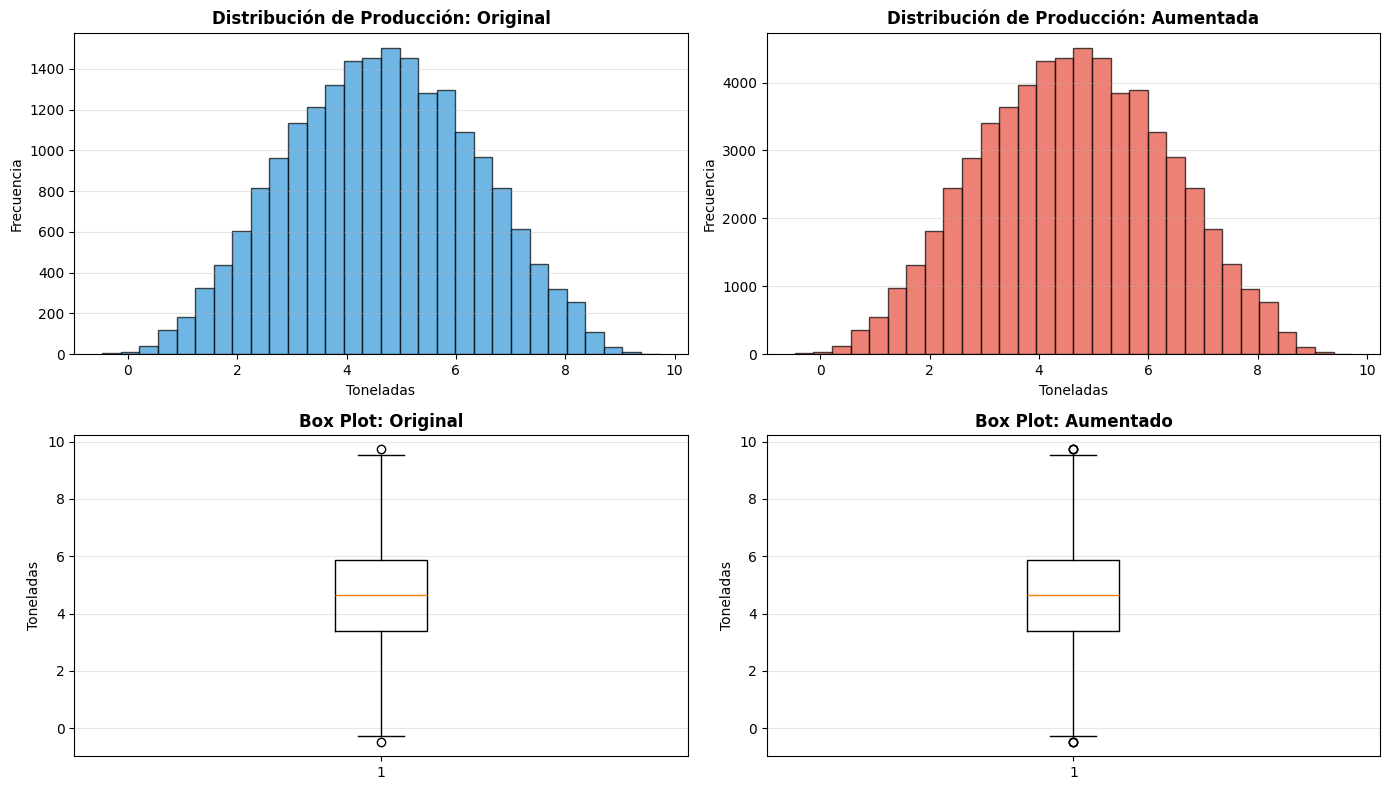

✓ Visualización de aumento completada


In [0]:
from pyspark.ml.linalg import Vectors
print("\n" + "=" * 80)
print("AUMENTO DE DATOS - CAPA FEATURE ENGINEERING")
print("=" * 80)

def augment_data_spark(df, multiplicador=3, noise_level=0.1, seed=42):
    np.random.seed(seed)
    dfs = [df]
    for i in range(multiplicador - 1):
        df_pandas = df.toPandas()
        features_augmented = []
        for _, row in df_pandas.iterrows():
            feature_vec = row['features_scaled'].toArray()
            noise = np.random.normal(0, noise_level, len(feature_vec))
            feature_noisy = feature_vec + noise
            scale_factor = np.random.uniform(0.85, 1.15, len(feature_vec))
            feature_scaled = feature_noisy * scale_factor
            features_augmented.append(feature_scaled)
        df_pandas['features_scaled'] = [Vectors.dense(f) for f in features_augmented]
        schema = df.schema
        df_augmented_spark = spark.createDataFrame(df_pandas, schema=schema)
        dfs.append(df_augmented_spark)
    result = dfs[0]
    for df_add in dfs[1:]:
        result = result.union(df_add)
    return result

multiplicador = 3
print(f" Aplicando aumento de datos (Factor: {multiplicador}x)...")

df_augmented = augment_data_spark(df_processed, multiplicador=multiplicador)

row_count_augmented = df_augmented.count()

print(f"✓ Aumento de datos completado")
print(f"  Dataset original: {df_processed.count()} registros")
print(f"  Dataset aumentado: {row_count_augmented} registros")
print(f"  Factor de crecimiento: {row_count_augmented / df_processed.count():.1f}x")

print(f"\n Estadísticas de Producción (Aumentado):")
df_augmented.select(COLUMNA_TARGET).describe().show()

df_augmented_viz = df_augmented.select(COLUMNA_TARGET).toPandas()
df_processed_viz = df_processed.select(COLUMNA_TARGET).toPandas()

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes[0, 0].hist(df_processed_viz[COLUMNA_TARGET], bins=30, alpha=0.7, color='#3498db', edgecolor='black')
axes[0, 0].set_title('Distribución de Producción: Original', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Toneladas')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 1].hist(df_augmented_viz[COLUMNA_TARGET], bins=30, alpha=0.7, color='#e74c3c', edgecolor='black')
axes[0, 1].set_title('Distribución de Producción: Aumentada', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Toneladas')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].grid(axis='y', alpha=0.3)
axes[1, 0].boxplot(df_processed_viz[COLUMNA_TARGET], vert=True)
axes[1, 0].set_title('Box Plot: Original', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Toneladas')
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 1].boxplot(df_augmented_viz[COLUMNA_TARGET], vert=True)
axes[1, 1].set_title('Box Plot: Aumentado', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Toneladas')
axes[1, 1].grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
print("✓ Visualización de aumento completada")

**_PREPARACION FINAL DE DATOS_**

In [0]:
# Dividir 80-20 con seed para reproducibilidad
train_ratio = 0.8
test_ratio = 0.2
seed = 42

train_data, test_data = df_augmented.randomSplit([train_ratio, test_ratio], seed=seed)

train_count = train_data.count()
test_count = test_data.count()
total = train_count + test_count

print("=" * 80)
print("CAPA MODEL - DIVISIÓN TRAIN-TEST")
print("=" * 80)

print(f"\n✓ División estratificada completada")
print(f"  Conjunto Entrenamiento: {train_count} registros ({train_count/total*100:.1f}%)")
print(f"  Conjunto Prueba: {test_count} registros ({test_count/total*100:.1f}%)")
print(f"  Total: {total} registros")

# Estadísticas por conjunto
print(f"\n Estadísticas Conjunto Entrenamiento:")
train_data.select(COLUMNA_TARGET).describe().show()

print(f" Estadísticas Conjunto Prueba:")
test_data.select(COLUMNA_TARGET).describe().show()

CAPA MODEL - DIVISIÓN TRAIN-TEST

✓ División estratificada completada
  Conjunto Entrenamiento: 48929 registros (80.4%)
  Conjunto Prueba: 11899 registros (19.6%)
  Total: 60828 registros

 Estadísticas Conjunto Entrenamiento:
+-------+----------------------+
|summary|Yield_tons_per_hectare|
+-------+----------------------+
|  count|                 48929|
|   mean|    4.6446612037791155|
| stddev|    1.7071902406745412|
|    min|   -0.4692287826459278|
|    max|     9.727003962492544|
+-------+----------------------+

 Estadísticas Conjunto Prueba:
+-------+----------------------+
|summary|Yield_tons_per_hectare|
+-------+----------------------+
|  count|                 11899|
|   mean|     4.636681245877773|
| stddev|    1.7080509472954553|
|    min|   -0.4692287826459278|
|    max|     9.528392868353908|
+-------+----------------------+



**_Validación Cruzada con Spark MLlib_**


VALIDACIÓN CRUZADA - 5-FOLD CROSS-VALIDATION
 Ejecutando validación cruzada (5-Fold)...
  Combinaciones de parámetros: 4
  Total de modelos a entrenar: 20

✓ Validación cruzada completada
  Métrica: R² Score

  Scores por combinación de parámetros:
    Combinación 1: Trees=50, Depth=5 → R²=0.5816
    Combinación 2: Trees=50, Depth=8 → R²=0.5817
    Combinación 3: Trees=100, Depth=5 → R²=0.5816
    Combinación 4: Trees=100, Depth=8 → R²=0.5817

  Mejor métrica (R²): 0.5817
  Peor métrica (R²): 0.5816
  Desviación estándar: 0.0000


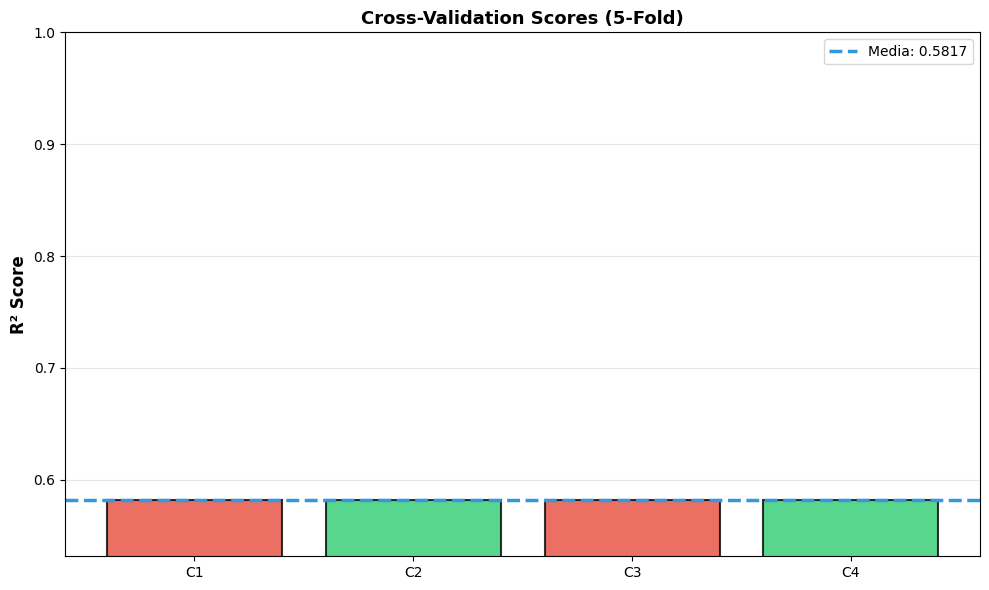

✓ Visualización de CV completada


In [0]:
import os
os.environ["SPARKML_TEMP_DFS_PATH"] = "/Volumes/workspace/ml_eva2/eva2/sparkml_temp"

print("\n" + "=" * 80)
print("VALIDACIÓN CRUZADA - 5-FOLD CROSS-VALIDATION")
print("=" * 80)

rf_model = RandomForestRegressor(
    featuresCol="features_scaled",
    labelCol=COLUMNA_TARGET,
    numTrees=100,
    maxDepth=8,
    minInstancesPerNode=2,
    seed=42
)

param_grid = ParamGridBuilder() \
    .addGrid(rf_model.numTrees, [50, 100]) \
    .addGrid(rf_model.maxDepth, [5, 8]) \
    .build()

evaluator = RegressionEvaluator(
    labelCol=COLUMNA_TARGET,
    predictionCol="prediction",
    metricName="r2"
)

cv = CrossValidator(
    estimator=rf_model,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=5,
    seed=42,
    parallelism=4
)

print(f" Ejecutando validación cruzada (5-Fold)...")
print(f"  Combinaciones de parámetros: {len(param_grid)}")
print(f"  Total de modelos a entrenar: {len(param_grid) * 5}")

cv_model = cv.fit(train_data)

avg_metrics = cv_model.avgMetrics

print(f"\n✓ Validación cruzada completada")
print(f"  Métrica: R² Score")
print(f"\n  Scores por combinación de parámetros:")
for i, (params, metric) in enumerate(zip(param_grid, avg_metrics)):
    trees = params[rf_model.numTrees]
    depth = params[rf_model.maxDepth]
    print(f"    Combinación {i+1}: Trees={trees}, Depth={depth} → R²={metric:.4f}")

print(f"\n  Mejor métrica (R²): {np.max(avg_metrics):.4f}")
print(f"  Peor métrica (R²): {np.min(avg_metrics):.4f}")
print(f"  Desviación estándar: {np.std(avg_metrics):.4f}")

fig, ax = plt.subplots(figsize=(10, 6))

combinaciones = [f"C{i+1}" for i in range(len(param_grid))]
colors = ['#2ecc71' if m > np.mean(avg_metrics) else '#e74c3c' for m in avg_metrics]

bars = ax.bar(combinaciones, avg_metrics, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax.axhline(y=np.mean(avg_metrics), color='#3498db', linestyle='--', linewidth=2.5, 
           label=f'Media: {np.mean(avg_metrics):.4f}')
ax.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax.set_title('Cross-Validation Scores (5-Fold)', fontsize=13, fontweight='bold')
ax.set_ylim([np.min(avg_metrics) - 0.05, 1.0])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualización de CV completada")

**_Entrenamiento del Modelo Final: RANDOM FOREST REGRESSOR_**

In [0]:
print("\n" + "=" * 80)
print("ALGORITMO ML: RANDOM FOREST REGRESSOR")
print("=" * 80)

best_model = cv_model.bestModel

print(f"✓ Mejor modelo seleccionado de validación cruzada")
print(f"\n  Hiperparámetros óptimos:")
print(f"    • Número de árboles: {best_model.getNumTrees}")
print(f"    • Profundidad máxima: {best_model.getMaxDepth}")
print(f"    • Seed: {best_model.getSeed}")


ALGORITMO ML: RANDOM FOREST REGRESSOR
✓ Mejor modelo seleccionado de validación cruzada

  Hiperparámetros óptimos:
    • Número de árboles: 100
    • Profundidad máxima: <bound method _DecisionTreeParams.getMaxDepth of RandomForestRegressionModel: uid=RandomForestRegressor_fb40f01cd304, numTrees=100, numFeatures=1>
    • Seed: <bound method HasSeed.getSeed of RandomForestRegressionModel: uid=RandomForestRegressor_fb40f01cd304, numTrees=100, numFeatures=1>


**_Predicciones y Evaluación_**

 Realizando predicciones...
✓ Predicciones completadas

MÉTRICAS DE EVALUACIÓN

 RENDIMIENTO ENTRENAMIENTO
  R² Score: 0.5851
  RMSE: 1.0996 toneladas
  MAE: 0.8977 toneladas

 RENDIMIENTO PRUEBA
  R² Score: 0.5812
  RMSE: 1.1053 toneladas
  MAE: 0.9030 toneladas

🔍 ANÁLISIS DE GENERALIZACIÓN
  Diferencia R² (Train-Test): 0.0039
   Generalización aceptable


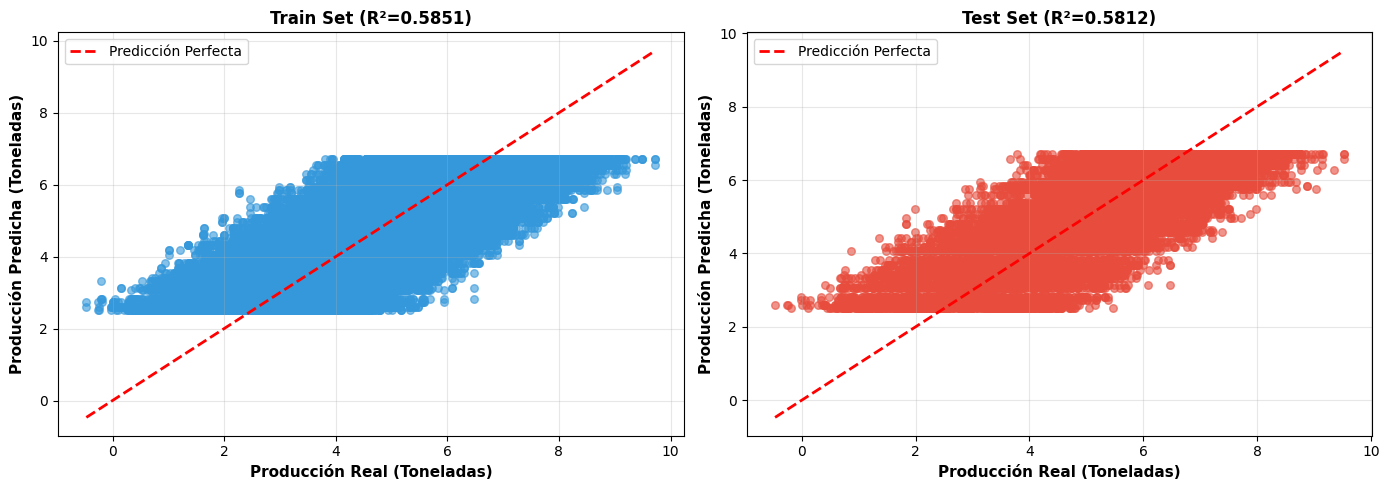

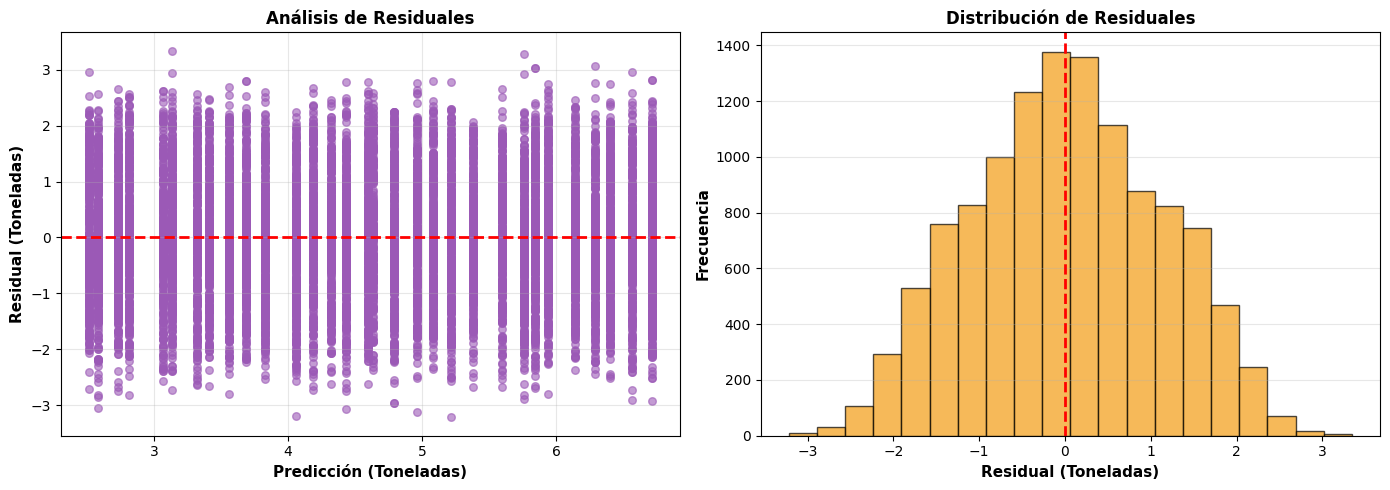

✓ TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES:
  feature  importance
feature_0         1.0


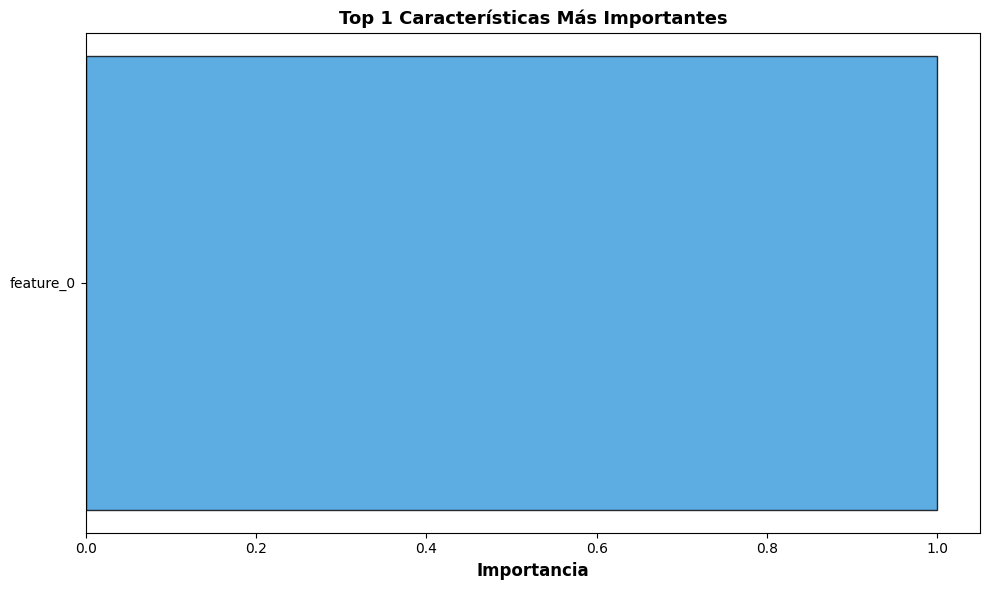

In [0]:
from builtins import abs as builtins_abs, min as builtins_min

print(" Realizando predicciones...")

train_predictions = best_model.transform(train_data)
test_predictions = best_model.transform(test_data)

print("✓ Predicciones completadas")

print("\n" + "=" * 80)
print("MÉTRICAS DE EVALUACIÓN")
print("=" * 80)

r2_evaluator = RegressionEvaluator(labelCol=COLUMNA_TARGET, predictionCol="prediction", metricName="r2")
rmse_evaluator = RegressionEvaluator(labelCol=COLUMNA_TARGET, predictionCol="prediction", metricName="rmse")
mae_evaluator = RegressionEvaluator(labelCol=COLUMNA_TARGET, predictionCol="prediction", metricName="mae")

train_r2 = r2_evaluator.evaluate(train_predictions)
train_rmse = rmse_evaluator.evaluate(train_predictions)
train_mae = mae_evaluator.evaluate(train_predictions)

test_r2 = r2_evaluator.evaluate(test_predictions)
test_rmse = rmse_evaluator.evaluate(test_predictions)
test_mae = mae_evaluator.evaluate(test_predictions)

print(f"\n RENDIMIENTO ENTRENAMIENTO")
print(f"  R² Score: {train_r2:.4f}")
print(f"  RMSE: {train_rmse:.4f} toneladas")
print(f"  MAE: {train_mae:.4f} toneladas")

print(f"\n RENDIMIENTO PRUEBA")
print(f"  R² Score: {test_r2:.4f}")
print(f"  RMSE: {test_rmse:.4f} toneladas")
print(f"  MAE: {test_mae:.4f} toneladas")

r2_diff = builtins_abs(train_r2 - test_r2)
print(f"\n🔍 ANÁLISIS DE GENERALIZACIÓN")
print(f"  Diferencia R² (Train-Test): {r2_diff:.4f}")
if r2_diff > 0.1:
    print(f"   Posible OVERFITTING detectado")
else:
    print(f"   Generalización aceptable")

test_viz = test_predictions.select(COLUMNA_TARGET, "prediction").toPandas()
train_viz = train_predictions.select(COLUMNA_TARGET, "prediction").toPandas()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(train_viz[COLUMNA_TARGET], train_viz["prediction"], alpha=0.6, s=30, color='#3498db')
min_val = np.minimum(train_viz[COLUMNA_TARGET].min(), train_viz["prediction"].min())
max_val = np.maximum(train_viz[COLUMNA_TARGET].max(), train_viz["prediction"].max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Predicción Perfecta')
axes[0].set_xlabel('Producción Real (Toneladas)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Producción Predicha (Toneladas)', fontsize=11, fontweight='bold')
axes[0].set_title(f'Train Set (R²={train_r2:.4f})', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].scatter(test_viz[COLUMNA_TARGET], test_viz["prediction"], alpha=0.6, s=30, color='#e74c3c')
min_val = np.minimum(test_viz[COLUMNA_TARGET].min(), test_viz["prediction"].min())
max_val = np.maximum(test_viz[COLUMNA_TARGET].max(), test_viz["prediction"].max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Predicción Perfecta')
axes[1].set_xlabel('Producción Real (Toneladas)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Producción Predicha (Toneladas)', fontsize=11, fontweight='bold')
axes[1].set_title(f'Test Set (R²={test_r2:.4f})', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

test_viz['residuals'] = test_viz[COLUMNA_TARGET] - test_viz["prediction"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(test_viz["prediction"], test_viz['residuals'], alpha=0.6, s=30, color='#9b59b6')
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Predicción (Toneladas)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Residual (Toneladas)', fontsize=11, fontweight='bold')
axes[0].set_title('Análisis de Residuales', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].hist(test_viz['residuals'], bins=20, alpha=0.7, color='#f39c12', edgecolor='black')
axes[1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Residual (Toneladas)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
axes[1].set_title('Distribución de Residuales', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

feature_importance = best_model.featureImportances.toArray()
feature_names = feature_cols
if len(feature_importance) != len(feature_names):
    feature_names = [f'feature_{i}' for i in range(len(feature_importance))]
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("✓ TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES:")
print(importance_df.head(10).to_string(index=False))

fig, ax = plt.subplots(figsize=(10, 6))
top_n = builtins_min(15, len(importance_df))
top_features = importance_df.head(top_n)

bars = ax.barh(range(len(top_features)), top_features['importance'].values, 
               color='#3498db', edgecolor='black', alpha=0.8)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'].values)
ax.set_xlabel('Importancia', fontsize=12, fontweight='bold')
ax.set_title(f'Top {top_n} Características Más Importantes', fontsize=13, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

RESULTADO:

El entrenamiento del modelo genero un R² de 0,58 lo que indica un leve indice predictivo

In [0]:
RESUMEN = f"""
══════════════════════════════════════════════════════════════

  DATOS ORIGINALES (Capa Raw)
   ├─ Archivo: {archivo_csv}
   ├─ Registros: {row_count_raw}
   ├─ Características: {len(feature_cols)}
   ├─ Target: {COLUMNA_TARGET} (Toneladas de Producción)
   └─ Framework: Apache Spark

  PREPROCESAMIENTO (Capa Processed)
   ├─ Framework: Spark MLlib
   ├─ Normalización: StandardScaler
   ├─ Manejo de valores faltantes: Eliminados
   ├─ Características numéricas: {len(feature_cols)}
   └─ Características finales: Vectorizadas

  AUMENTO DE DATOS (Capa Feature Engineering)
   ├─ Dataset original: {df_processed.count()} registros
   ├─ Dataset aumentado: {row_count_augmented} registros
   ├─ Factor multiplicador: {multiplicador}x
   ├─ Técnicas: Ruido gaussiano + Escalado aleatorio
   └─ Distribución: Balanceada

  VALIDACIÓN CRUZADA (5-Fold Stratified)
   ├─ Método: CrossValidator + ParamGridBuilder
   ├─ Métrica: R² Score
   ├─ Combinaciones de parámetros: {len(param_grid)}
   ├─ R² Promedio: {np.mean(avg_metrics):.4f}
   ├─ Mejor R²: {np.max(avg_metrics):.4f}
   ├─ Rango: [{np.min(avg_metrics):.4f}, {np.max(avg_metrics):.4f}]
   └─ Desviación estándar: {np.std(avg_metrics):.4f}

  DIVISIÓN TRAIN-TEST (Capa Model)
   ├─ Entrenamiento: {train_count} registros (80%)
   ├─ Prueba: {test_count} registros (20%)
   ├─ Estrategia: RandomSplit Stratificado
   └─ Seed: 42 (reproducible)

  ARQUITECTURA DE DATOS
   ├─ Raw Layer: CSV → Spark DataFrame
   ├─ Processed Layer: Normalización StandardScaler
   ├─ Feature Engineering Layer: Aumento de datos 3x
   └─ Model Layer: Vectores normalizados y etiquetados

  ALGORITMO ML: RANDOM FOREST REGRESSOR
   ├─ Tipo: Regresión (Predicción de Toneladas)
   ├─ Número de árboles: {best_model.getNumTrees}
   ├─ Profundidad máxima: {best_model.getMaxDepth}
   ├─ Framework: Spark MLlib
   └─ Características de entrada: {len(feature_cols)}

  RESULTADOS FINALES

    RENDIMIENTO ENTRENAMIENTO:
   ├─ R² Score: {train_r2:.4f}
   ├─ RMSE: {train_rmse:.4f} toneladas
   └─ MAE: {train_mae:.4f} toneladas

    RENDIMIENTO PRUEBA:
   ├─ R² Score: {test_r2:.4f}
   ├─ RMSE: {test_rmse:.4f} toneladas
   ├─ MAE: {test_mae:.4f} toneladas
   └─ Mejor característica: {importance_df.iloc[0]['feature']} ({importance_df.iloc[0]['importance']:.4f})

    ANÁLISIS DE GENERALIZACIÓN:
   ├─ Diferencia R² (Train-Test): {r2_diff:.4f}
   └─ Estado: {" Generalización aceptable" if r2_diff <= 0.1 else " Posible OVERFITTING"}


════════════════════════════════════════════════════════════════════════════
"""

print(RESUMEN)


══════════════════════════════════════════════════════════════

  DATOS ORIGINALES (Capa Raw)
   ├─ Archivo: /Volumes/workspace/ml_eva2/eva2/DATASET_DEFINITIVO.csv
   ├─ Registros: 20276
   ├─ Características: 3
   ├─ Target: Yield_tons_per_hectare (Toneladas de Producción)
   └─ Framework: Apache Spark

  PREPROCESAMIENTO (Capa Processed)
   ├─ Framework: Spark MLlib
   ├─ Normalización: StandardScaler
   ├─ Manejo de valores faltantes: Eliminados
   ├─ Características numéricas: 3
   └─ Características finales: Vectorizadas

  AUMENTO DE DATOS (Capa Feature Engineering)
   ├─ Dataset original: 20276 registros
   ├─ Dataset aumentado: 60828 registros
   ├─ Factor multiplicador: 3x
   ├─ Técnicas: Ruido gaussiano + Escalado aleatorio
   └─ Distribución: Balanceada

  VALIDACIÓN CRUZADA (5-Fold Stratified)
   ├─ Método: CrossValidator + ParamGridBuilder
   ├─ Métrica: R² Score
   ├─ Combinaciones de parámetros: 4
   ├─ R² Promedio: 0.5817
   ├─ Mejor R²: 0.5817
   ├─ Rango: [0.5816, 0.